In [12]:
import csv

import numpy as np
import pandas as pd
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from keras.src.layers import LSTM
from keras import Sequential

In [13]:
# 读取数据
df = pd.read_csv('vmd_sh_data2.csv')

# 将日期列转换为日期类型
df["date"] = pd.to_datetime(df["date"])

# 将 object 类型的列转换为 float64
object_cols = df.select_dtypes(include=['object']).columns
df[object_cols] = df[object_cols].apply(lambda x: x.str.replace(',', '').astype(float))

# 根据年份划分训练集和测试集
train_data = df[df["date"].dt.year.between(2013, 2020)]
test_data = df[df["date"].dt.year.between(2021, 2023)]

# 定义特征列和目标列
features = ['BIAS', 'BOLL', 'MACD', 'VMACD', 'MA', 'RSI', 'KDJ', 'change', 'trading_volume', 'trading_value', 'IMF1', 'IMF2', 'IMF3']
target = 'change_percent'

# 获取训练集和测试集的特征和目标变量
X_train = train_data[features]
y_train = train_data[target].values.reshape(-1, 1)  # 调整形状以适应归一化
X_test = test_data[features]
y_test = test_data[target].values.reshape(-1, 1)  # 调整形状以适应归一化

# 初始化归一化器
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# 对特征和目标变量进行归一化
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)  # 对y进行归一化
y_test_scaled = scaler_y.transform(y_test)  # 对y进行归一化

# 调整数据的形状以适应模型
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# LSTM

In [14]:
def model_lstm(time_step, input_dim):
    model = Sequential()
    model.add(LSTM(128, activation="relu", input_shape=(time_step, input_dim), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, activation="relu", return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, activation="relu", return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    opt = Adam(learning_rate=1e-4)
    model.compile(loss='mse', optimizer=opt, metrics=['mse'])
    model.summary()
    return model

model = model_lstm(time_step=1, input_dim=X_train.shape[1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 128)            72704     
                                                                 
 dropout_3 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 64)             49408     
                                                                 
 dropout_4 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [15]:
# 训练模型
history = model.fit(X_train_reshaped, y_train_scaled, epochs=1000
                    , batch_size=32, validation_data=(X_test_reshaped, y_test_scaled), verbose=1)

Epoch 1/1000
61/61 [==============================] - 1s 5ms/step - loss: 0.3600 - mse: 0.3600 - val_loss: 0.3418 - val_mse: 0.3418
Epoch 2/1000
61/61 [==============================] - 0s 3ms/step - loss: 0.3411 - mse: 0.3411 - val_loss: 0.3177 - val_mse: 0.3177
Epoch 3/1000
61/61 [==============================] - 0s 4ms/step - loss: 0.3069 - mse: 0.3069 - val_loss: 0.2637 - val_mse: 0.2637
Epoch 4/1000
61/61 [==============================] - 0s 3ms/step - loss: 0.2237 - mse: 0.2237 - val_loss: 0.1245 - val_mse: 0.1245
Epoch 5/1000
61/61 [==============================] - 0s 4ms/step - loss: 0.0854 - mse: 0.0854 - val_loss: 0.0153 - val_mse: 0.0153
Epoch 6/1000
61/61 [==============================] - 0s 3ms/step - loss: 0.0552 - mse: 0.0552 - val_loss: 0.0147 - val_mse: 0.0147
Epoch 7/1000
61/61 [==============================] - 0s 3ms/step - loss: 0.0473 - mse: 0.0473 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 8/1000
61/61 [==============================] - 0s 3ms/step - loss: 0.

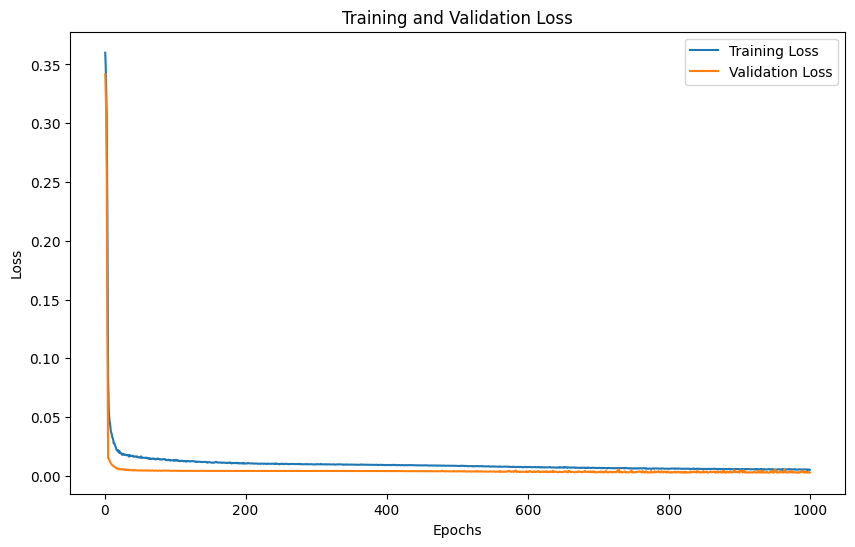

In [16]:
# 提取训练损失和验证损失
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 获取训练周期数
epochs = range(1, len(train_loss) + 1)

# 绘制训练损失和验证损失的曲线
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [17]:
# 对测试集进行预测
y_pred_scaled = model.predict(X_test_reshaped)

# 反归一化预测结果
# y_pred = (y_pred_scaled * mean_std_train['std'][0]) + mean_std_train['mean'][0]

# 使用相同的 scaler_y 实例来反归一化预测值
y_pred = scaler_y.inverse_transform(y_pred_scaled)

23/23 [==============================] - 0s 806us/step


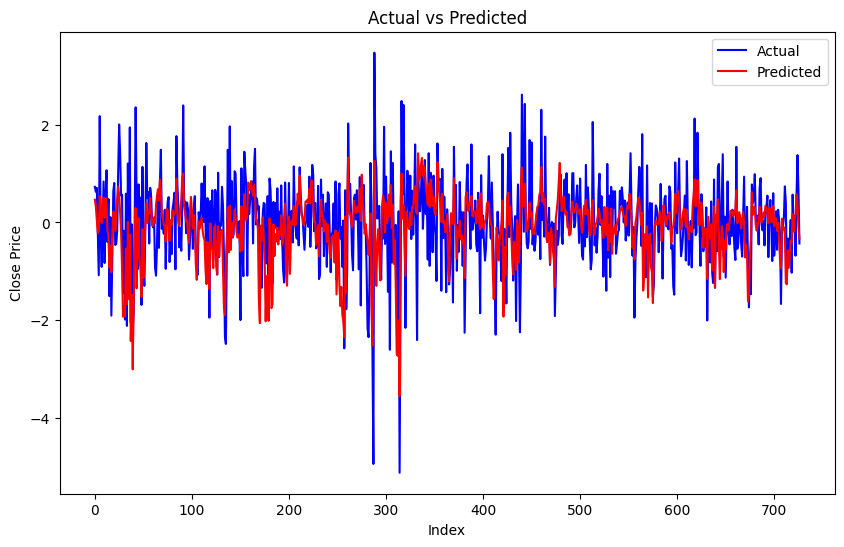

In [18]:
# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.title('Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [19]:
# 检查 y_test 和 y_pred 的维度
print("y_test 维度:", y_test.ndim)
print("y_pred 维度:", y_pred.ndim)

y_test 维度: 2
y_pred 维度: 2


In [20]:
y_test
y_pred

array([[ 4.67602670e-01],
       [ 3.22382301e-01],
       [ 5.82090281e-02],
       [-2.14408636e-01],
       [-1.79356992e-01],
       [ 5.38775325e-01],
       [ 5.97964935e-02],
       [-8.48235749e-03],
       [ 4.85344231e-01],
       [ 5.04590034e-01],
       [ 9.95332450e-02],
       [ 4.95943487e-01],
       [ 3.52601886e-01],
       [-1.73995793e-01],
       [-2.65511602e-01],
       [-9.26659167e-01],
       [-4.75873291e-01],
       [-1.02153504e+00],
       [-1.93464115e-01],
       [ 2.24760398e-01],
       [ 1.50744930e-01],
       [-1.70774147e-01],
       [ 2.18177810e-01],
       [ 4.65486914e-01],
       [ 7.33833134e-01],
       [ 5.71712911e-01],
       [ 2.18360424e-01],
       [-1.91140249e-01],
       [-9.46372926e-01],
       [-1.93109286e+00],
       [-1.72585917e+00],
       [-1.92694747e+00],
       [-5.34212828e-01],
       [-1.68010473e+00],
       [ 1.20680574e-02],
       [-1.57332242e+00],
       [-2.45266959e-01],
       [-2.43006706e+00],
       [-1.4

In [21]:
# 将二维数组展平为一维数组，然后创建 DataFrame
df2 = pd.DataFrame({'Actual': y_test[:, 0], 'Predicted': y_pred[:, 0]})

# 计算新列，即相减结果
df2['Difference'] = df2['Actual'] - df2['Predicted']

# 将 DataFrame 保存为 CSV 文件
df2.to_csv('LSTM_output.csv', index=False)


In [22]:
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def mean_bias_error(y_true, y_pred):
    return np.mean(y_pred - y_true)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mean_squared_logarithmic_error(y_true, y_pred):
    y_true_log = np.log1p(np.maximum(0, y_true))
    y_pred_log = np.log1p(np.maximum(0, y_pred))
    return np.mean((y_true_log - y_pred_log)**2)

def root_mean_squared_logarithmic_error(y_true, y_pred):
    return np.sqrt(mean_squared_logarithmic_error(y_true, y_pred))

def normalized_root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean(((y_true - y_pred) / (np.max(y_true) - np.min(y_true)))**2))


# 将损失函数结果保存到CSV文件
def save_to_csv(loss_results):
    with open('LSTM_loss.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Loss Function", "Value"])
        for loss_name, loss_value in loss_results.items():
            writer.writerow([loss_name, loss_value])

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mbe = mean_bias_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
msle = mean_squared_logarithmic_error(y_test, y_pred)
rmsle = root_mean_squared_logarithmic_error(y_test, y_pred)
nrmse = normalized_root_mean_squared_error(y_test, y_pred)

loss_results = {
    "MAE": mae,
    "MSE": mse,
    "MBE": mbe,
    "RMSE": rmse,
    "MSLE": msle,
    "RMSLE": rmsle,
    "NRMSE": nrmse,
}
with open('LSTM_loss.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Loss Function", "Value"])
    for loss_name, loss_value in loss_results.items():
        writer.writerow([loss_name, loss_value])
        
save_to_csv(loss_results)

print("MAE:", mae)
print("MSE:", mse)
print("MBE:", mbe)
print("RMSE:", rmse)
print("MSLE:", msle)
print("RMSLE:", rmsle)
print("NRMSE:", nrmse)

MAE: 0.5670046098623793
MSE: 0.5672340512726893
MBE: -0.07970853840204775
RMSE: 0.7531494216108044
MSLE: 0.0776783580459414
RMSLE: 0.2787083745529391
NRMSE: 0.08747380041937335
